# Exploring model output: orbits and weights

In this notebook we will look at the output of a Schwarzschild model in more detail. We will access the orbit library and the orbital weights for the model that we ran previously.

As a side note, in this tutorial we will also see the that our current description of the line-of-sight velocity distribution - i.e. the Gauss Hermite expansion - has some undesirable features. This is the motivation for one of our upcoming code developments: using better descriptions of the LOSVD.

Let's re-create the model that we previously ran

In [1]:
import dynamite as dyn

fname = 'NGC6278_config.yaml'
c = dyn.config_reader.Configuration(fname)

parset = c.parspace.get_parset()

model = dyn.model.Model(config=c, parset=parset)
orblib0 = model.get_orblib()
weight_solver0 = model.get_weights()

To read the orbit library for this model, we can do the following,

In [2]:
orblib0.read_losvd_histograms()

This creates the object``Orblib.LegacyOrbitLibrary.losvd_histograms`` with the following properties

In [3]:
print(f'Orbits are stored in a {type(orblib0.losvd_histograms)}')
print(f'That contains this object: {orblib0.losvd_histograms[0]}')

Orbits are stored in a <class 'list'>
That contains this object: <dynamite.kinematics.Histogram object at 0x1108aed60>


The histogram is stored in a list, so to access it, we need to call the first list element. This object has two attributes, ``x``, and ``y``, which are the velocity array, and and array of LOSVDs of the orbit library respectively. These arrays have the following shapes,

In [4]:
print(f'velocity array has shape {orblib0.losvd_histograms[0].x.shape}')
print(f'LOSVD has shape {orblib0.losvd_histograms[0].y.shape}')

velocity array has shape (267,)
LOSVD has shape (360, 267, 152)


Where do these numbers come from? They are set by values in the configuration file.

The size of the first dimension of the LOSVD - 360 - is the number of orbits in our library. This comes from three values which we also specified by values in the configuration file, i.e.

In [5]:
tmp = c.settings.orblib_settings
print('nE = ', tmp['nE'])
print('nI2 = ', tmp['nI2'])
print('nI3 = ', tmp['nI3'])
print('ndithering = ', tmp['dithering'])

nE =  6
nI2 =  5
nI3 =  4
ndithering =  1


E, I2 and I3 are orbital integrals of motion. A grid over these values is used to specify initial conditions for the orbit library. Dithering is a the number of additional orbits which are calculated to regularise the solution. 

In [6]:
n_orbit_bundles = tmp['nE'] * tmp['nI2'] * tmp['nI3']
n_orbits_per_bundle = tmp['dithering']**3
size_of_box_orblib = n_orbits_per_bundle * n_orbit_bundles
# tube orbits can be reflected, so we have twice as many tube orbits as box orbits
size_of_tube_orblib = 2 * n_orbit_bundles * n_orbits_per_bundle 
size_of_total_orblib = size_of_box_orblib + size_of_tube_orblib
print('Total orbit library size =', size_of_total_orblib)

Total orbit library size = 360


The size of the second dimension of the LOSVD corresponds to the size of the velocity array.

The third dimension size of the LOSVD - 152 - is the number of spatial apertures. It should be equal to the number of spatial apertures for which we have provided kinematic data, i.e. the number of rows of the kinematic data file, i.e.

In [7]:
len(c.system.cmp_list[2].kinematic_data[0].data)

152

So - in summary - the LOSVD histogram has shape

$$
(n_\mathrm{orbits}, n_\mathrm{velocityBins}, n_\mathrm{apertures})
$$

i.e. we have one LOSVD per orbit and per spatial aperture. Let's write a simple plotting routine to look at some examples,

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_losvds(losvd_histogram, orb_idx, aperture_idx_list):
    v = losvd_histogram[0].x
    losvd = losvd_histogram[0].y[orb_idx, :, :]
    plt.plot(v, np.sum(losvd, 1), label='total')
    for aperture_idx in aperture_idx_list:
        plt.plot(v,
                 losvd[:, aperture_idx],
                 '--',
                 label=f'aperture {aperture_idx}')
    plt.gca().set_title(f'LOSVD of orbit {orb_idx}')
    plt.gca().set_xlabel('v [km/s]')
    plt.gca().set_yscale('log')
    plt.gca().legend()
    plt.tight_layout()
    return

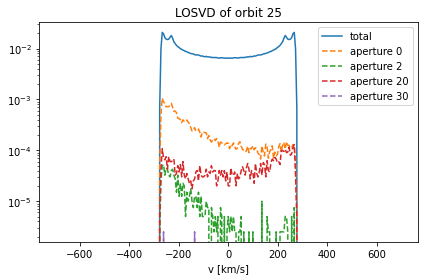

In [9]:
orb_idx = 25
aperture_idx_list = [0, 2, 20, 30]
plot_losvds(orblib0.losvd_histograms, orb_idx, aperture_idx_list)

In some apertures, this orbit hardly contributes at all. One of these orbits looks interesting - the one in aperture 20. Let's plot this one on its own,

**Exercise**: plot the LOSVD of orbit 19 in apertures 0, 7, 9

**Exercise**: which orbit has the narrowest LOSVD in aperture 0? Which orbit has the broadest LOSVD?

One of the LOSVDs that we plotted above (orbit 25 in aperture 20) looks interesting. Let's focus in on it,

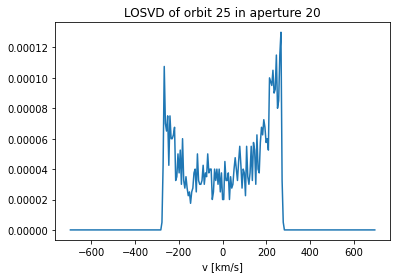

In [10]:
orb_idx, aperture_idx = 25, 20
v_arr = orblib0.losvd_histograms[0].x
losvd = orblib0.losvd_histograms[0].y[orb_idx, :, aperture_idx]

plt.plot(v_arr, losvd)
plt.gca().set_xlabel('v [km/s]')
title = f'LOSVD of orbit {orb_idx} in aperture {aperture_idx}'
_ = plt.gca().set_title(title)

It's bimodal!

**Exercise**: can you find any other bimodal LOSVDs in the orbit library?

In order to compare the orbits we have calculated to the observations, we must transform the kinematics of the orbit LOSVDs into their Gauss Hermite representations. Let's see how well Gauss Hermite expansion can do at reproducing the bimodal LOSVD above. The function to do the transformation from orbits to observed kinematics is held in the kinematcs object itself, so let's extract this,

In [11]:
kinematics = c.system.cmp_list[2].kinematic_data[0]

and now extract the observed $v$ and sigma in the aperture of interest,

In [12]:
# extracting observed v, sigma in a given aperture

# get the row of the table kinematics.dat which corresponds to the aperture of interest
row_idx = np.where(kinematics.data['vbin_id']==aperture_idx)[0][0]
# extract v and sigma from that for of the table
v, sigma = kinematics.data[row_idx]['v', 'sigma']
# print result
print(f'In aperture {aperture_idx}:')
print(f'   v = {v} km/s')
print(f'   sigma = {sigma} km/s')

In aperture 20:
   v = -4.9067 km/s
   sigma = 130.4659 km/s


Now let's fit a Gauss Hermite distribution to the orbit's LOSVD. When we solved for the orbital weights earlier, this was all done "under-the-hood". Now we can see it in action,

In [13]:
# create a histogram object of the losvds for all apertures and orbits first
losvd = orblib0.losvd_histograms[0].y[:, :, :]

## velocity histograms where vel_hist.y has shape (n_orbits, n_vbins, n_regions)
velhist = dyn.kinematics.Histogram(
    xedg=orblib0.losvd_histograms[0].xedg,
    y=losvd)

v     = kinematics.data[:]['v']
sigma = kinematics.data[:]['sigma']

# get a gauss hermite expansion to this LOSVD
gh_coefficients = kinematics.get_gh_expansion_coefficients(
    v_mu=v,
    v_sig=sigma,
    vel_hist=velhist,
    max_order=4)

# remove unused empty dimension
tmp = np.squeeze(gh_coefficients)

# print best-fit gauss hermite coefficients
print(f'GH coefficients for orbit {orb_idx} and aperture {aperture_idx}:')
i = 1
for hi in tmp[orb_idx,aperture_idx,:]:
    print(f'   h_{i} = {hi:.4f}')
    i+=1

GH coefficients for orbit 25 and aperture 20:
   h_1 = 0.0237
   h_2 = 0.0038
   h_3 = 0.0090
   h_4 = -0.0022
   h_5 = -0.0087


Now let's look at the LOSVD given by these Gauss Hermite coefficients,

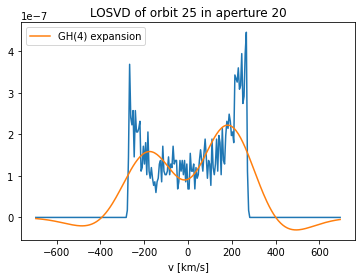

In [14]:
# evaluate the losvd
gh_losvd = kinematics.evaluate_losvd(velhist.x,
                                     np.array(v),
                                     np.array(sigma),
                                     gh_coefficients)
# remove unused empty dimension
gh_losvd = np.squeeze(gh_losvd)

# normalise the two LOSVDs so that we can plot them on the same axis
losvd /= np.sum(losvd) 
gh_losvd /= np.sum(gh_losvd)

# plot the LOSVDs
plt.plot(v_arr, losvd[orb_idx,:,aperture_idx])
plt.plot(v_arr, gh_losvd[orb_idx,aperture_idx,:], label='GH(4) expansion')
plt.gca().legend()
plt.gca().set_xlabel('v [km/s]')
title = f'LOSVD of orbit {orb_idx} in aperture {aperture_idx}'
_ = plt.gca().set_title(title)

The Gauss Hermite parameterisation of the LOSVD does an OK job at reproducing the bimodality of the LOSVD, although the peaks are somewhat underpredicted. The wings of the profile are significantly negative however. This isn't good! Negative LOSVDs are unphysical. The fact that Gauss Hermite expansions become negative could bias our modelling. This is one of our key motivations for wanting to replace Gauss Hermites with different parametrisations of the LOSVD.

**Exercise**: fit higher order GH expansions to the above LOSVD. How high do you need to go to improve the match and eliminate negative wings?

**Exercise**: fit a GH expansion to the LOSVD of orbit 14 in aperture 19. Compare this to the histogrammed LOSVD in a plot.

## Looking at the orbital weights

Now let's look at the best fitting orbital weights,

In [15]:
weight_solver0.read_weights()
weight_solver0.weights

orb_idx,E_idx,I2_idx,I3_idx,totalnotregularizable,orb_type,weight,lcut
int64,int64,int64,int64,int64,int64,float64,int64
1,1,1,1,0,3,0.00601477,-1
2,1,-1,1,0,3,0.0,-1
3,1,1,2,0,3,0.0,-1
4,1,-1,2,0,3,0.0,-1
5,1,1,3,0,3,0.0,-1
6,1,-1,3,0,3,0.0,-1
7,1,1,4,0,3,3.72684e-05,-1
8,1,-1,4,0,3,0.0,-1
9,1,2,1,0,3,0.00589513,-1


There is a row for every orbit, a weight for every orbit. To extract the weights column of this table, we can do the following,

In [16]:
weight_solver0.weights['weight']

0.00601477
0.0
0.0
0.0
0.0
0.0
3.72684e-05
0.0
0.00589513
0.0
0.010152


What does the LOSVD look like for this set of weights? To produce this, we need to weigh the orbit library LOSVDs by the orbital weights.

In [17]:
# extract the orbital weights
w = weight_solver0.weights['weight']

# extract the model LOSVD
orbit_losvds = orblib0.losvd_histograms[0].y

# dot product of model losvd and weights
model_losvd = np.dot(orbit_losvds.T, w).T

# normalise the model losvds so that later we can plot them on the same y-axis as the previous plots
model_losvd /= np.sum(model_losvd, 0)

print('model_losvd has shape = ', model_losvd.shape)

model_losvd has shape =  (267, 152)


This array is the model LOSVD. The first dimension corresponds to the velocity array, the second is the number of spatial apertures.

**Exercise**: plot the model LOSVD in apertures 0, 20 and 50.

Let's compare the model LOSVD to to observed Gauss Hermite LOSVD in aperture 20,

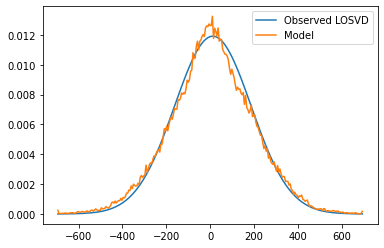

In [18]:
aperture_idx = 20

# extract v, sigma and GH corefficients of the observed LOSVD in out aperture
v, sigma, h3, h4 = kinematics.data[aperture_idx]['v', 'sigma', 'h3', 'h4']
# set h0, h1 and h2 to their defaults
h0, h1, h2 = 1., 0., 0.
# combine all gh coefficients to one array
gh_coefficients = np.array([[[h0, h1, h2, h3, h4]]])

# evaluate the LOSVD of this 
gh_losvd_obs = kinematics.evaluate_losvd(velhist.x,
                                     np.array([v]),
                                     np.array([sigma]),
                                     gh_coefficients)
# remove un-used dimensions
gh_losvd_obs = np.squeeze(gh_losvd_obs)
# normalise
gh_losvd_obs /= np.sum(gh_losvd_obs)

# plot the 
plt.plot(v_arr, np.squeeze(gh_losvd_obs), label='Observed LOSVD')
plt.plot(v_arr, model_losvd[:, aperture_idx], label='Model')
plt.gca().legend()

The model and observed LOSVD have similar widths. But the sharp, spiky peak in the model LOSVDs is not seen in the obseved LOSVD.

The model LOSVD we just plotted is generated directly from the histogrammed LOSVDs of the orbits. We could instead look at the model LOSVD coming from the Gauss Hermite representation of the orbit library.

(267, (267, 152))

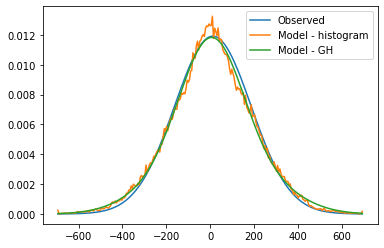

In [19]:
aperture_idx = 20

# extract the losvd of all orbits.
tmp = orblib0.losvd_histograms[0].y[:,:,]

# store them in a histogram object
vel_hist = dyn.kinematics.Histogram(
    xedg=orblib0.losvd_histograms[0].xedg,
    y=tmp,
    normalise=False)


# get the GH expansion coefficients for all of these orbits
gh_coefficients = kinematics.get_gh_expansion_coefficients(
    v_mu=kinematics.data['v'][aperture_idx],
    v_sig=kinematics.data['sigma'][aperture_idx],
    vel_hist=vel_hist,
                max_order=4)


# evaluate the losvd given these GH coefficients
gh_model_losvd = kinematics.evaluate_losvd(
    velhist.x,
    kinematics.data['v'][[aperture_idx]],
    kinematics.data['sigma'][[aperture_idx]],
    gh_coefficients)


# remove un-used dimensionsy<a
gh_model_losvd = np.squeeze(gh_model_losvd)

# weigh the GH LOSVDs by the orbital weights
gh_model_losvd = np.dot(gh_model_losvd.T, w).T

# normalise
gh_model_losvd = gh_model_losvd[aperture_idx,:]
gh_model_losvd /= np.sum(gh_model_losvd)

# plot them
plt.plot(v_arr, np.squeeze(gh_losvd_obs), label='Observed')
plt.plot(v_arr, model_losvd[:, aperture_idx], label='Model - histogram')
plt.plot(v_arr, gh_model_losvd, label='Model - GH')
plt.gca().legend()
len(v_arr), model_losvd.shape

The GH representation of the model is a better match to the observations, both in the wings and the body of the distribution. The Gauss Hermite expansion at order 4 has not, however, been able to reproduce the very sharp peak in the histogrammed version of the model LOSVD.